Waveplate indices: 8, 9
a_avg = 0.463 ± 0.019
b_avg = -0.326 ± 0.028
cos(delta) = -0.704 ± -0.066 (stat only)
delta (rad) = 2.352 ± 0.094 (combined)
delta (deg) = 134.77 ± 5.39 (combined)


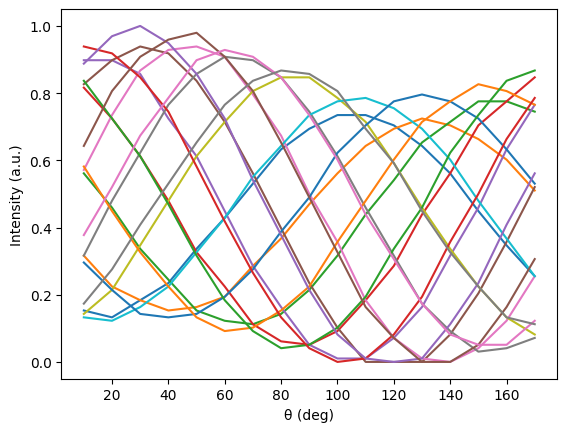

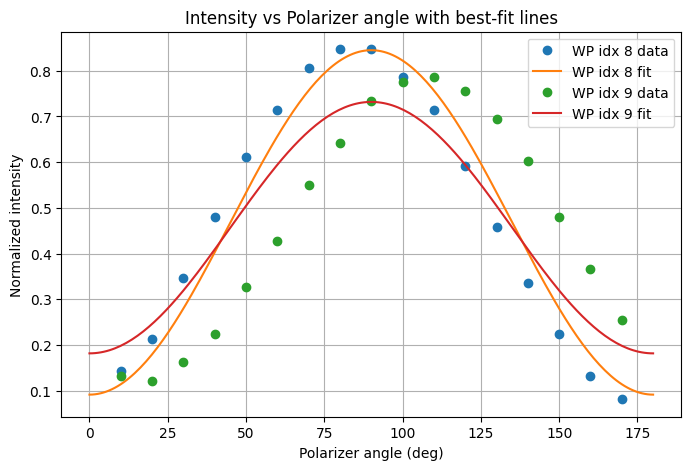

In [94]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def read_data2(path):
    df = pd.read_csv(path, comment='#')
    angle_deg = df.iloc[:, 0].values
    angle_rad = np.deg2rad(angle_deg)
    intensities = df.iloc[:, 1:].values
    intensities_rad = intensities.T
    return angle_rad, intensities_rad

# ----------------------------------------------------
# DEFINE FIT FUNCTION
# ----------------------------------------------------
def linear_cos(theta, a, b):
    return a + b * np.cos(2*theta)

# ----------------------------------------------------
# FIND WAVEPLATE NEAR 90 DEGREES
# ----------------------------------------------------
def near90(intensities, angles):
    theta_90 = np.deg2rad(90)
    idx_theta = np.argmin(np.abs(angles - theta_90))
    intens_at_90 = intensities[:, idx_theta]
    idx_max = np.argmax(intens_at_90)
    return idx_max - 1 if idx_max >= len(intensities) - 1 else idx_max

# ----------------------------------------------------
# PLOT AVERAGED FIT VS cos(2theta)
# ----------------------------------------------------
def plot_avg_fit_vs_cos2theta(a_avg, b_avg, t,c):
    theta_plot = np.linspace(0, np.pi, 200)
    I_avg = a_avg + b_avg * np.cos(2 * theta_plot)
    cos2theta = np.cos(2 * theta_plot)
    
    plt.figure(figsize=(10,6))
    plt.plot(cos2theta, I_avg, '-', color=c, label=t)
    plt.xlabel("cos(2θ)")
    plt.ylabel("Intensity (a.u.)")
    plt.grid(True)
    plt.ylim(0,1)
    plt.legend()
    plt.show()

# ----------------------------------------------------
# ANALYZE TWO WAVEPLATES WITH ERRORS
# ----------------------------------------------------
def analyze_two_wp(intensities, angles, idx1, idx2, N_mc=1000, angle_err_deg=1):
    I1 = intensities[idx1]
    I2 = intensities[idx2]

    # --- Step 1: Fit original data ---
    popt1, pcov1 = curve_fit(linear_cos, angles, I1, p0=[np.mean(I1), (np.max(I1)-np.min(I1))/2])
    popt2, pcov2 = curve_fit(linear_cos, angles, I2, p0=[np.mean(I2), (np.max(I2)-np.min(I2))/2])

    a1, b1 = popt1
    a2, b2 = popt2

    # Fit errors from covariance
    a1_err, b1_err = np.sqrt(np.diag(pcov1))
    a2_err, b2_err = np.sqrt(np.diag(pcov2))

    # Average parameters
    a_avg = (a1 + a2)/2
    b_avg = (b1 + b2)/2
    a_avg_err = np.sqrt(a1_err**2 + a2_err**2)/2
    b_avg_err = np.sqrt(b1_err**2 + b2_err**2)/2

    # --- Step 2: Monte Carlo for angle uncertainty ---
    angle_err_rad = np.deg2rad(angle_err_deg)
    delta_mc_list = []

    for _ in range(N_mc):
        angles_perturbed = angles + np.random.normal(0, angle_err_rad, size=angles.shape)
        popt1_mc, _ = curve_fit(linear_cos, angles_perturbed, I1, p0=[a1, b1])
        popt2_mc, _ = curve_fit(linear_cos, angles_perturbed, I2, p0=[a2, b2])
        a_avg_mc = (popt1_mc[0] + popt2_mc[0]) / 2
        b_avg_mc = (popt1_mc[1] + popt2_mc[1]) / 2
        cos_delta_mc = b_avg_mc / a_avg_mc
        delta_mc = np.arccos(np.clip(cos_delta_mc, -1, 1))
        delta_mc_list.append(delta_mc)

    delta_sys_err = np.std(delta_mc_list)  # systematic error from angle uncertainty

    # --- Step 3: Combine statistical and systematic errors ---
    cos_delta = b_avg / a_avg
    # statistical error from fit
    cos_delta_stat_err = cos_delta * np.sqrt((b_avg_err/b_avg)**2 + (a_avg_err/a_avg)**2)
    # delta statistical error
    delta_stat_err = cos_delta_stat_err / np.sqrt(1 - cos_delta**2)

    # Combine errors in quadrature
    delta = np.arccos(np.clip(cos_delta, -1, 1))
    delta_total_err = np.sqrt(delta_stat_err**2 + delta_sys_err**2)

    # --- Step 4: Print results ---
    print(f"Waveplate indices: {idx1}, {idx2}")
    print(f"a_avg = {a_avg:.3f} ± {a_avg_err:.3f}")
    print(f"b_avg = {b_avg:.3f} ± {b_avg_err:.3f}")
    print(f"cos(delta) = {cos_delta:.3f} ± {cos_delta_stat_err:.3f} (stat only)")
    print(f"delta (rad) = {delta:.3f} ± {delta_total_err:.3f} (combined)")
    print(f"delta (deg) = {np.degrees(delta):.2f} ± {np.degrees(delta_total_err):.2f} (combined)")

    ii = 0
    for yc in intensities:
        ii = ii + 1
        plt.plot(np.degrees(angles), yc, label = str(ii))
    plt.xlabel("θ (deg)")
    plt.ylabel("Intensity (a.u.)")
    #plt.legend()

    # --- Step 5: Plot fits ---
    theta_fit = np.linspace(0, np.pi, 200)
    plt.figure(figsize=(8,5))
    plt.plot(np.degrees(angles), I1, 'o', label=f"WP idx {idx1} data")
    plt.plot(np.degrees(theta_fit), linear_cos(theta_fit, *popt1), '-', label=f"WP idx {idx1} fit")
    plt.plot(np.degrees(angles), I2, 'o', label=f"WP idx {idx2} data")
    plt.plot(np.degrees(theta_fit), linear_cos(theta_fit, *popt2), '-', label=f"WP idx {idx2} fit")
    plt.xlabel("Polarizer angle (deg)")
    plt.ylabel("Normalized intensity")
    plt.title("Intensity vs Polarizer angle with best-fit lines")
    plt.legend()
    plt.grid(True)
    plt.show()

    return delta, a_avg, b_avg, delta_total_err

def all(intensities, angles, smooth=False):
    plt.figure(figsize=(10,6))
    num_wp = intensities.shape[0]

    x_deg = np.degrees(angles)
    
    for i in range(num_wp):
        y = intensities[i]
        if smooth:
            # Create more points for a smooth curve
            x_smooth = np.linspace(x_deg.min(), x_deg.max(), 500)
            spline = make_interp_spline(x_deg, y, k=3)  # Cubic spline
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f'WP {i}', linewidth=0.9)
        else:
            plt.plot(x_deg, y, label=f'WP {i}', linewidth=0.9)
    
    plt.xlabel("θ (deg)")
    plt.ylabel("Intensity (a.u.)")
    #plt.legend(ncol=2, fontsize=9)
    plt.grid(True)
    plt.show()

# ----------------------------------------------------
# LOAD DATA
# ----------------------------------------------------
file_path = "/Users/lucas/Desktop/physics/Year 3/Project 1/dat/cello/1strech.csv"
angles, intensities = read_data2(file_path)  
theta = angles
intensities_norm = intensities / np.max(intensities)

# 5: 14, 16
# 3: 3, 4
# 7: 14, 15
# strech: 8,9

delta, a_avg, b_avg, delta_err = analyze_two_wp(intensities_norm, angles, 8,9)
#plot_avg_fit_vs_cos2theta(a_avg, b_avg, "n=2", "red")